In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
rawdf = pd.read_csv('Training_Data_Set_yes24_UTF8.txt',  sep=',')

In [3]:
rawdf.head(1)

,"﻿""일자""",구분,회원번호,책제목,카테고리,작가,ISBN,출판사,출판일자,주문시간,수량,카트적재여부,카트적재일자,모바일구분,배송주소1,배송주소2
0,20140928,주문,65856,무의미의 축제,해외문학,<밀란 쿤데라> 저/<방미경> 역,9788937489327,민음사,20140723,22,1,N,NaN,기기PID_PC,서울특별시,동작구


In [4]:
# Change header first
headers={rawdf.columns[0]:'Date', '구분':'Class', '회원번호':'ID', '책제목':'Title', '카테고리':'Category', '작가':'Author',
         '출판사':'Publisher', '출판일자':'Pub_Date', '주문시간':'Order_Time', '수량':'Count', '카트적재여부':'Cart',
         '카트적재일자':'Cart_Date', '모바일구분':'Device','배송주소1':'Address1','배송주소2':'Address2'}
rawdf.rename(columns=headers, inplace=True)
rawdf.head(1)

,Date,Class,ID,Title,Category,Author,ISBN,Publisher,Pub_Date,Order_Time,Count,Cart,Cart_Date,Device,Address1,Address2
0,20140928,주문,65856,무의미의 축제,해외문학,<밀란 쿤데라> 저/<방미경> 역,9788937489327,민음사,20140723,22,1,N,NaN,기기PID_PC,서울특별시,동작구


In [5]:
print 'We have following default columns:'
for i, item in enumerate(rawdf.columns):
    print i+1, item

We have following default columns:
1 Date
2 Class
3 ID
4 Title
5 Category
6 Author
7 ISBN
8 Publisher
9 Pub_Date
10 Order_Time
11 Count
12 Cart
13 Cart_Date
14 Device
15 Address1
16 Address2


In [6]:
# Modifications on Address and ISBN

rawdf['Address1'].loc[rawdf['Address1']=='강원']='강원도'
rawdf['Address1'].loc[rawdf['Address1']=='경기']='경기도'
rawdf['Address1'].loc[rawdf['Address1']=='경남']='경상남도'
rawdf['Address1'].loc[rawdf['Address1']=='경북']='경상북도'
rawdf['Address1'].loc[rawdf['Address1']=='광주']='광주광역시'
rawdf['Address1'].loc[rawdf['Address1']=='대구']='대구광역시'
rawdf['Address1'].loc[rawdf['Address1']=='대전']='대전광역시'
rawdf['Address1'].loc[rawdf['Address1']=='부산']='부산광역시'
rawdf['Address1'].loc[rawdf['Address1']=='서울']='서울특별시'
rawdf['Address1'].loc[rawdf['Address1']=='세종']='세종특별자치시'
rawdf['Address1'].loc[rawdf['Address1']=='울산']='울산광역시'
rawdf['Address1'].loc[rawdf['Address1']=='인천']='인천광역시'
rawdf['Address1'].loc[rawdf['Address1']=='전남']='전라남도'
rawdf['Address1'].loc[rawdf['Address1']=='전북']='전라북도'
rawdf['Address1'].loc[rawdf['Address1']=='제주']='제주특별자치도'
rawdf['Address1'].loc[rawdf['Address1']=='충남']='충청남도'
rawdf['Address1'].loc[rawdf['Address1']=='충북']='충청북도'

rawdf['ISBN']=rawdf['ISBN'].apply(lambda r: str(r).strip())
rawdf['ISBN'].loc[rawdf['ISBN']=='-']=''
rawdf['ISBN'].loc[rawdf['ISBN']=='nan']=''

/Users/hankyuljoo/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# tmpdf = rawdf[rawdf['ID']==82348]
# print tmpdf[tmpdf['Class']=='주문'].shape, tmpdf[tmpdf['Class']=='취소'].shape,  tmpdf[tmpdf['Class']=='환불'].shape

# # tmpdf[tmpdf['ISBN']=='9788971847244']
# tmpdf[tmpdf['Class']=='취소']
# tmpdf[tmpdf['ISBN']=='9788937460296']

In [8]:
# tmpdf[tmpdf['ISBN']=='9788971847244']

In [9]:
# def remove_return_cancel(indf):

#     canceldf = indf[indf['Class'].isin(['취소','환불'])][['ID','Title']]
#     canceldf['index'] = canceldf.index
#     group = canceldf.groupby(['ID','Title'])

#     del_p = []
#     for cid, tit, cnt in zip(group['ID'].head(), group['Title'].head(), group.size()):

#         purchlist = list(indf[(indf.ID==cid)  & (indf.Class=='주문') & (indf.Title== tit)][['Class','Title']].index)
        
#         ind = 0
#         for item in purchlist:
#             while ind < cnt:
#                 del_p.append(item)
#                 ind += 1

#     return indf.drop(del_p)

# remove_return_cancel(tmpdf)


In [9]:
def rm_return_cancel(indf):
    
    def ret(group):

        datadict = {}
        datadict['Ret_ID'] = list(group['ID'])[0]
        datadict['Ret_Count'] = len(group['ID'])
        datadict['Ret_Index'] = list(group['index'])

        redf = pd.DataFrame([datadict])
        redf.set_index('Ret_ID',inplace=True)
        return redf

    def purch(group):

        datadict = {}
        datadict['Pur_ID'] = list(group['ID'])[0]
        datadict['Pur_Count'] = len(group['ID'])
        datadict['Pur_Index'] = list(group['index'])

        redf = pd.DataFrame([datadict])
        redf.set_index('Pur_ID',inplace=True)
        return redf

    def total_index(df):
        return df['Pur_Index'][:df['Removing_Count']]+ df['Ret_Index'][:df['Removing_Count']]    
    
    df_c = indf[indf['Class'].isin(['취소','환불'])][['ID','Title']]
    df_c['index']= df_c.index
    df_cnew = df_c.groupby(['ID','Title']).apply(ret).reset_index()
    df_cnew = df_cnew[['Title','ID','Ret_Count','Ret_Index']]

    df_p = indf[indf['Class'].isin(['주문'])][['ID','Title']]
    df_p['index'] = df_p.index
    df_pnew = df_p.groupby(['ID','Title']).apply(purch).reset_index()
    df_pnew = df_pnew[['Title','ID','Pur_Count','Pur_Index']]

    merg = pd.merge(df_pnew, df_cnew, on=['ID','Title'])
    merg['Removing_Count'] = merg[['Ret_Count', 'Pur_Count']].min(axis=1)
#     merg['Removing_Index'] = ''
    merg['Removing_Index'] = merg.apply(total_index,axis=1)
    rem_list = merg['Removing_Index'].sum()
    
    return rem_list

In [10]:
%%time

print rawdf[rawdf['Class']=='주문'].shape, rawdf[rawdf['Class']=='취소'].shape,  rawdf[rawdf['Class']=='환불'].shape
remlist = rm_return_cancel(rawdf)
rawdf = rawdf.drop(remlist)
print rawdf[rawdf['Class']=='주문'].shape, rawdf[rawdf['Class']=='취소'].shape,  rawdf[rawdf['Class']=='환불'].shape

(511742, 16) (19264, 16) (3877, 16)
(488874, 16) (55, 16) (218, 16)
CPU times: user 13min 56s, sys: 40.3 s, total: 14min 36s
Wall time: 15min 11s


In [213]:
answerdf = rawdf[rawdf['Class'].isin(['취소','환불'])]
answerdf.to_csv("Data_Should_Be_In_Competition_Test_Set.csv", index=False)

cleardf = rawdf[rawdf['Class']=='주문']
cleardf.to_csv("Data_WO_CancelReturn.csv", index=False)
# cleardf = pd.read_csv("Data_WO_CancelReturn.csv")

We remove transaction pairs of (purchase, cancel) and (purchase, return). In our given data set, not all purchase transaction data are included (those information seem to be splitted into the test set). 
```
                    주문      캔슬      리턴   
    Given data :   511742,  19264,   3877
      New data :   488874,     55,    218 
```
The 273 transactions of cancel and return do not have corresponding purchase transactions in the given data. We'll drop remaining 273 transactions as well, and only consider 488,874 transactions.

In [24]:
# Narrow Down to Five Categories

FocusCategory = ['인문','자기계발','국내문학','해외문학','종교']
Alldf = cleardf[cleardf['Category'].isin(FocusCategory)]

print '# of entire data : ', len(rawdf), ' # of 5 category data : ',len(Alldf)
Alldf.groupby('Category').size()

# of entire data :  489147  # of 5 category data :  108171


Category
국내문학    24756
인문      17657
자기계발    18594
종교      12613
해외문학    34551
dtype: int64

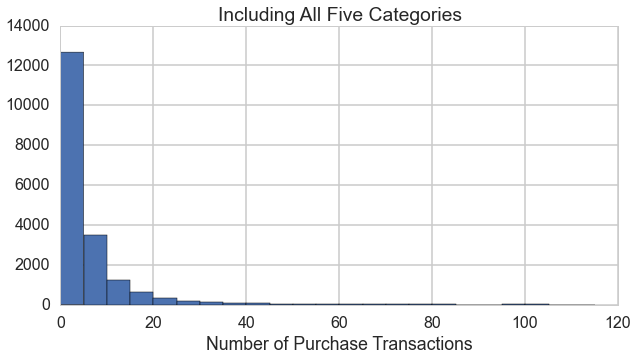

In [31]:
plt.figure(figsize=(10,5))
Alldf.groupby('ID').size().hist(bins=range(0,120,5))
plt.title('Including All Five Categories');
plt.xlabel('Number of Purchase Transactions')

In [33]:
# Add columns of ['user_purchase_count'] and ['book_sell_count']
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('ID')
    user_purchase_count=ldfu.Title.count()
    ldfb=ldf.groupby('Title')    
    book_sell_count=ldfb.ID.count()
    
    nldf=ldf.copy()
    nldf.set_index(['ID'], inplace=True)
    nldf['user_purchase_count']=user_purchase_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['Title'], inplace=True)
    nldf['book_sell_count']=book_sell_count    
    nldf.reset_index(inplace=True)
    return nldf

Alldf = recompute_frame(Alldf)
Humdf = recompute_frame(Alldf[Alldf['Category']=='인문'])
Seldf = recompute_frame(Alldf[Alldf['Category']=='자기계발'])
Domdf = recompute_frame(Alldf[Alldf['Category']=='국내문학'])
Fordf = recompute_frame(Alldf[Alldf['Category']=='해외문학'])
Regdf = recompute_frame(Alldf[Alldf['Category']=='종교'])

len(Alldf), len(Humdf), len(Seldf), len(Domdf), len(Fordf), len(Regdf)

(108171, 17657, 18594, 24756, 34551, 12613)

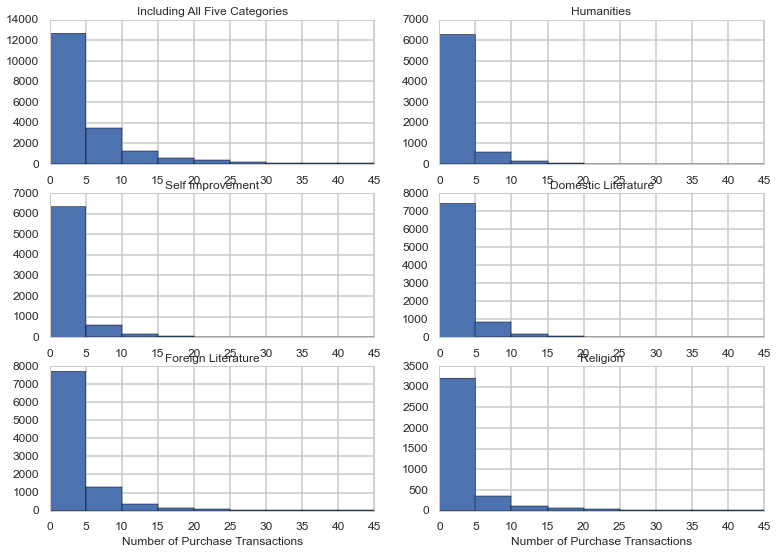

In [54]:
sz = 12
plt.subplot(3,2,1); Alldf.groupby('ID').size().hist(bins=range(0,50,5))
plt.title('Including All Five Categories',size=sz); plt.xticks(size=sz); plt.yticks(size=sz);

plt.subplot(3,2,2); Humdf.groupby('ID').size().hist(bins=range(0,50,5))
plt.title('Humanities',size=sz); plt.xticks(size=sz); plt.yticks(size=sz);

plt.subplot(3,2,3); Seldf.groupby('ID').size().hist(bins=range(0,50,5))
plt.title('Self Improvement',size=sz); plt.xticks(size=sz); plt.yticks(size=sz);

plt.subplot(3,2,4); Domdf.groupby('ID').size().hist(bins=range(0,50,5))
plt.title('Domestic Literature',size=sz); plt.xticks(size=sz); plt.yticks(size=sz);

plt.subplot(3,2,5); Fordf.groupby('ID').size().hist(bins=range(0,50,5))
plt.title('Foreign Literature',size=sz); plt.xlabel('Number of Purchase Transactions',size=sz)
plt.xticks(size=sz); plt.yticks(size=sz);

plt.subplot(3,2,6); Regdf.groupby('ID').size().hist(bins=range(0,50,5))
plt.title('Religion',size=sz); plt.xlabel('Number of Purchase Transactions',size=sz)
plt.xticks(size=sz); plt.yticks(size=sz);

In [188]:
def train_test_splitting(indf, take, testtake, over):
        
    trainlist=[]
    testlist=[]
    validatelist=[]
    for k, v in indf.groupby('ID'):
        if np.mean(v.user_purchase_count) > over:
            takenos=np.random.choice(range(take), size=testtake, replace=False)
            takelist=np.array([e in takenos for e in range(take)])
            validatelist.append(v[-take:][~takelist])#use those 
            testlist.append(v[-take:][takelist])#use the other 
            trainlist.append(v[:-take])
        else:
            trainlist.append(v)
    traindf=pd.concat(trainlist)
    validatedf=pd.concat(validatelist)
    testdf=pd.concat(testlist)
    print traindf.shape, validatedf.shape, testdf.shape

    return traindf, validatedf, testdf

In [153]:
print Alldf[Alldf.user_purchase_count>10].shape
print Humdf[Humdf.user_purchase_count>7].shape
print Seldf[Seldf.user_purchase_count>4].shape
print Fordf[Fordf.user_purchase_count>6].shape
print Regdf[Regdf.user_purchase_count>4].shape
print Domdf[Domdf.user_purchase_count>6].shape

(57243, 18)
(4990, 18)
(8422, 18)
(16766, 18)
(7507, 18)
(9117, 18)


In [206]:
All_traindf, All_validatedf, All_testdf = train_test_splitting(Alldf, take=12, testtake=5, over=12) # take: total take

(84387, 18) (13874, 18) (9910, 18)


In [205]:
Hum_traindf, Hum_validatedf, Hum_testdf = train_test_splitting(Humdf, take=7, testtake=3, over=7) # take: total take

(15053, 18) (1488, 18) (1116, 18)


In [204]:
For_traindf, For_validatedf, For_testdf = train_test_splitting(Fordf, take=10, testtake=4, over=10) # take: total take

(28851, 18) (3420, 18) (2280, 18)


In [203]:
Dom_traindf, Dom_validatedf, Dom_testdf = train_test_splitting(Domdf, take=10, testtake=4, over=10) # take: total taket 2

(21726, 18) (1818, 18) (1212, 18)


In [201]:
Reg_traindf, Reg_validatedf, Reg_testdf = train_test_splitting(Regdf, take=7, testtake=3, over=7) # take: total take

(10394, 18) (1268, 18) (951, 18)


In [197]:
Sel_traindf, Sel_validatedf, Sel_testdf = train_test_splitting(Seldf, take=7, testtake=3, over=7) # take: total take

(15808, 18) (1592, 18) (1194, 18)


In [198]:
for i in range(10):
    trdf, vadf, tsdf = Sel_traindf, Sel_validatedf, Sel_testdf
    exampleid = trdf['ID'][list(np.random.choice(range(1,1000),1))[0]]
    print len(trdf[trdf['ID']==exampleid]), len(vadf[vadf['ID']==exampleid]), len(tsdf[tsdf['ID']==exampleid])

5 4 3
4 4 3
1 0 0
6 0 0
5 0 0
3 0 0
1 0 0
21 4 3
2 0 0
2 0 0


In [207]:
All_traindf.to_csv("All_train.csv", index=False)
All_validatedf.to_csv("All_validate.csv", index=False)
All_testdf.to_csv("All_test.csv", index=False)

In [208]:
Hum_traindf.to_csv("Hum_train.csv", index=False)
Hum_validatedf.to_csv("Hum_validate.csv", index=False)
Hum_testdf.to_csv("Hum_test.csv", index=False)

In [209]:
For_traindf.to_csv("For_train.csv", index=False)
For_validatedf.to_csv("For_validate.csv", index=False)
For_testdf.to_csv("For_test.csv", index=False)

In [210]:
Dom_traindf.to_csv("Dom_train.csv", index=False)
Dom_validatedf.to_csv("Dom_validate.csv", index=False)
Dom_testdf.to_csv("Dom_test.csv", index=False)

In [211]:
Reg_traindf.to_csv("Reg_train.csv", index=False)
Reg_validatedf.to_csv("Reg_validate.csv", index=False)
Reg_testdf.to_csv("Reg_test.csv", index=False)

In [212]:
Sel_traindf.to_csv("Sel_train.csv", index=False)
Sel_validatedf.to_csv("Sel_validate.csv", index=False)
Sel_testdf.to_csv("Sel_test.csv", index=False)